In [1]:
import pandas as pd
import os
import sys
from db_utils import RDSDatabaseConnector
from data_extraction import DataExtractor
from data_transformer import DataTransformer
from data_frame_info import DataFrameInfo
from plotter import Plotter
current_directory = os.getcwd()


We begin by first extracting our data from an RDS database 
Ensure you have a yaml_file initialised with the correct credentials to access the RDS Database


In [2]:
# Path to the credentials file
yaml_file = "credentials.yaml"

# Initialize the database connector
db_connector = RDSDatabaseConnector(yaml_file)


# Initialize the data extractor with the database connector's engine
data_extractor = DataExtractor(db_connector.engine)

# Task 3 Step 6: Extract data from the 'customer_activity' table
table_name = "customer_activity"
data = data_extractor.read_rds_table(table_name)


Our db_connector utilizes the credentials from the YAML file to initialize a SQLAlchemy engine for database connections. 
This engine is passed to our data_extractor, enabling it to retrieve the customer activity data. 

We save this data into a CSV file on our local machine to avoid repeatedly connecting to the database, thereby accelerating our exploratory data analysis process.

In [3]:
csv_file_path = os.path.join(current_directory, 'customer_activity.csv')
data_extractor.save_to_csv(data, csv_file_path) # Saving data to a CSV file

Next step will be to load the data onto our panda dataframe, and to gather information on the nature of our dataset
so we can decide what the best way to clean/transform it is.



In [4]:
# Loading our data onto a dataframe
df = pd.read_csv(csv_file_path)

# Display the first few rows of the dataframe
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   administrative            11760 non-null  float64
 1   administrative_duration   11418 non-null  float64
 2   informational             12330 non-null  int64  
 3   informational_duration    11994 non-null  float64
 4   product_related           11751 non-null  float64
 5   product_related_duration  12129 non-null  float64
 6   bounce_rates              12330 non-null  float64
 7   exit_rates                12330 non-null  float64
 8   page_values               12330 non-null  float64
 9   month                     12330 non-null  object 
 10  operating_systems         12319 non-null  object 
 11  browser                   12330 non-null  object 
 12  region                    12330 non-null  object 
 13  traffic_type              12330 non-null  object 
 14  visito

,administrative,administrative_duration,informational,informational_duration,product_related,product_related_duration,bounce_rates,exit_rates,page_values,month,operating_systems,browser,region,traffic_type,visitor_type,weekend,revenue
0,0.0,0.0,0,0.0,4.0,0.0,0.2000,0.200,0.0,May,Android,Google Chrome,North America,Twitter,Returning_Visitor,False,False
1,0.0,0.0,0,0.0,26.0,876.0,0.0000,0.026,0.0,Nov,Windows,Google Chrome,Western Europe,Google search,Returning_Visitor,True,False
2,2.0,99.4,0,0.0,19.0,368.0,0.0396,0.052,0.0,Sep,Windows,Google Chrome,Asia,Twitter,Returning_Visitor,False,False
3,0.0,0.0,0,0.0,20.0,1432.0,0.0248,0.028,1.8,Dec,Windows,Google Chrome,Western Europe,Instagram ads,Returning_Visitor,False,True
4,0.0,0.0,0,0.0,33.0,694.0,0.0141,0.032,0.0,May,Android,Google Chrome,North America,Instagram ads,Returning_Visitor,False,False


# Dataset Description

The dataset consists of 17 columns with various data types and contains 12,330 entries. Below is a brief description of each column:

- **administrative**: Number of administrative pages visited by the user.
- **administrative_duration**: Duration spent on administrative pages.
- **informational**: Number of informational pages visited by the user.
- **informational_duration**: Duration spent on informational pages.
- **product_related**: Number of product-related pages visited by the user.
- **product_related_duration**: Duration spent on product-related pages.
- **bounce_rates**: Percentage of visitors who enter the site and then leave ("bounce") rather than continuing to view other pages within the same site.
- **exit_rates**: Percentage of pageviews on the site that were the last in the session.
- **page_values**: Metrics assigned to a page to quantify its economic value.
- **month**: Month of the year when the activity was recorded.
- **operating_systems**: Type of operating system used by the visitor.
- **browser**: Type of browser used by the visitor.
- **region**: Geographical region of the visitor.
- **traffic_type**: Source of the traffic, such as search engines or social media.
- **visitor_type**: Whether the visitor is new or returning.
- **weekend**: Whether the activity was recorded on a weekend.
- **revenue**: Whether the visit resulted in a transaction.

From our analysis we can see that we have various columns which dont have their data_types initilised, they are in "object" format. From the title of these columns they appear to be categorical, before converting it we will take a closer look.

In [5]:
# df_info = DataFrameInfo(df)
# print(df['month'].unique())
# print(df['region'].unique())
# print(df['traffic_type'].unique())
# print(df['visitor_type'].unique())
# print(df['browser'].unqiue())
print("Number of distinct values in each column:")
df[['month','operating_systems', 'browser', 'region', 'traffic_type', 'visitor_type']].nunique()

Number of distinct values in each column:


month                10
operating_systems     7
browser              13
region                9
traffic_type         19
visitor_type          3
dtype: int64

Our assumption is correct, they all have limited unique values, meaning it would make sense to change the column to categorical data type. This will not only conserve memory but allow us to do specialised analysis later on if we deem necessary. We will use our DataTransformer class, a class we created in 'data_transformer.py' to handle this dataset.

In [6]:
data_transformer = DataTransformer(df)
df = data_transformer.convert_columns(['month','operating_systems', 'browser', 'region', 'traffic_type', 'visitor_type'], dtype='category')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   administrative            11760 non-null  float64 
 1   administrative_duration   11418 non-null  float64 
 2   informational             12330 non-null  int64   
 3   informational_duration    11994 non-null  float64 
 4   product_related           11751 non-null  float64 
 5   product_related_duration  12129 non-null  float64 
 6   bounce_rates              12330 non-null  float64 
 7   exit_rates                12330 non-null  float64 
 8   page_values               12330 non-null  float64 
 9   month                     12330 non-null  category
 10  operating_systems         12319 non-null  category
 11  browser                   12330 non-null  category
 12  region                    12330 non-null  category
 13  traffic_type              12330 non-null  cate

The next step will be to  take a closer look at our null values and decide how to handle it.
In the data_frame_info.py I have creaeted a clas with various methods to retrieve information. 

In [7]:
# Preforming further inspection
df_info = DataFrameInfo(df)
df_info.null_percentage()



administrative              4.622871
administrative_duration     7.396594
informational               0.000000
informational_duration      2.725061
product_related             4.695864
product_related_duration    1.630170
bounce_rates                0.000000
exit_rates                  0.000000
page_values                 0.000000
month                       0.000000
operating_systems           0.089213
browser                     0.000000
region                      0.000000
traffic_type                0.000000
visitor_type                0.000000
weekend                     0.000000
revenue                     0.000000
dtype: float64

### Handling Missing Data

The columns with the missing values are:

- **administrative**: 4.62% missing
- **administrative_duration**: 7.40% missing
- **product_related**: 4.70% missing
- **informational_duration**: 2.73% missing
- **product_related_duration**: 1.630170
- **operating_systems**: 0.089213%

#### Addressing Missing Data

We have several options for handling missing data:

1. **Drop the rows or columns with missing values.**
2. **Replace the missing values with statistical measures such as the mean, mode, or median.**
3. **Apply advanced imputation methods like K-Nearest Neighbors (KNN).**

#### Missing Data Mechanisms

Before proceeding, it is important to determine if our missing data is Missing Completely At Random (MCAR) or Not Missing At Random (NMAR).

- **MCAR**: The missingness is independent of any observed or unobserved data. This means the missing data does not depend on other values in the dataset. For instance, if the missing values in `informational_duration` were randomly distributed, it would be considered MCAR. This type of missing data introduces little to no bias.

- **NMAR**: The missingness depends on unobserved data. For example, if users who spend very short or very long times on administrative pages are more likely to have missing values in `administrative_duration`, then the data is NMAR. This tpye of misisng data can introduce significant bias and will require advanced stastistical techniques to address.

#### Example from Our Dataset

Consider the `administrative_duration` column, which has 7.40% missing values. If these missing values are NMAR, it could be due to technical issues such as session timeouts for long durations. If we ignore this and impute using the mean or median, we risk skewing our results. 

For example, if users who spend longer on administrative pages are not recorded, we might incorrectly conclude that shorter page durations are more effective for user engagement and generating revenue. This could lead us to reduce the amount of content on administrative pages, potentially harming the user experience and negatively impacting business outcomes. 

### Next Step

We wil run a stastistical test to see if our msising data is **MCAR** or **NMAR**

A more detailed analysis, such as examining correlations between `administrative_duration` and other variables, followed by statistical tests, can help determine the nature of the missingness. If the missingness is related to the values, we would need to employ more sophisticated imputation methods or account for the missingness in our modeling process.


In [8]:
import pandas as pd
from pyampute.exploration.mcar_statistical_tests import MCARTest

# Load the dataset
data_mcar = pd.read_csv("customer_activity.csv")

# Select the specified column - Must be numerical types.
specified_columns = data_mcar[['administrative', 'administrative_duration', 'product_related', 'informational_duration', 'exit_rates', 'product_related_duration', 'page_values', 'bounce_rates', 'informational']]

# Apply the Little's MCAR test to the specified columns
mt = MCARTest(method="little")
print(mt.little_mcar_test(specified_columns))



0.9495907221356985


### Testing for Missing Completely At Random (MCAR)

We will be running Little's MCAR test to determine if the missing data in our dataset is missing completely at random.

**Null Hypothesis (H0):** The data is missing completely at random (MCAR).

**Alternative Hypothesis (H1):** The data is not missing completely at random (not MCAR).

We will use a p-value to determine the result of the test:
- If the p-value is greater than the significance level (commonly 0.05), we fail to reject the null hypothesis, indicating the data is MCAR.
- If the p-value is less than or equal to the significance level, we reject the null hypothesis, indicating the data is not MCAR.


In [9]:
import pandas as pd
from pyampute.exploration.mcar_statistical_tests import MCARTest

# Load the dataset
data_mcar = pd.read_csv("customer_activity.csv")

# Select the specified columns - must be numerical types
specified_columns = data_mcar[['administrative', 'administrative_duration', 'product_related', 'informational_duration', 'exit_rates', 'product_related_duration', 'page_values', 'bounce_rates', 'informational']]

# Apply the Little's MCAR test to the specified columns
mt = MCARTest(method="little")
test_result = mt.little_mcar_test(specified_columns)

# Print the test result and determine the outcome
print("Little's MCAR test result:", test_result)
p_value = test_result
if p_value > 0.05:
    print("Not enough evidence to reject the null hypothesis. The data is MCAR.")
else:
    print("Reject the null hypothesis. The data is not MCAR.")

Little's MCAR test result: 0.9495907221356985
Not enough evidence to reject the null hypothesis. The data is MCAR.


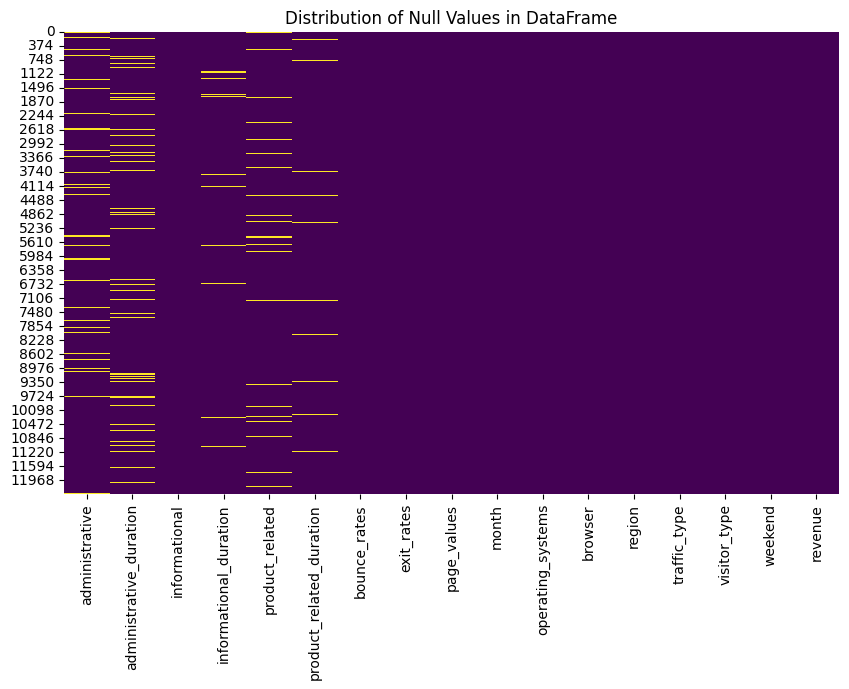

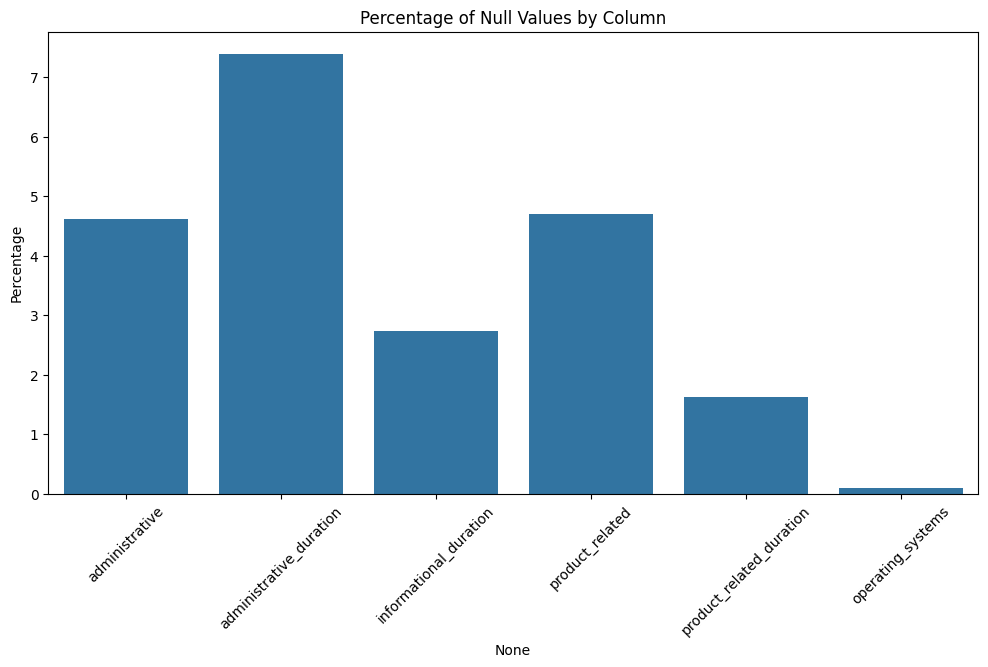

In [10]:
# Create an instance of the Plotter class
plotter = Plotter()

# Plot the distribution of null values before handling them
plotter.plot_null_distribution(df)
plotter.plot_null_percentage(df)


In [11]:
columns_remove_null = ['administrative', 'administrative_duration', 'product_related']
df = data_transformer.remove_null(columns_remove_null)
df = data_transformer.impute_null(['product_related_duration'], 'mean')
df = data_transformer.impute_null(['operating_systems'], 'mode')
df = data_transformer.impute_null(['informational_duration'], 'mean')

/home/msyislam/aicore/Exploratory-Data-Analysis---Online-Shopping-In-Retail/data_transformer.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df[column] = self.df[column].fillna(value)


After transforming the data this is the current change:



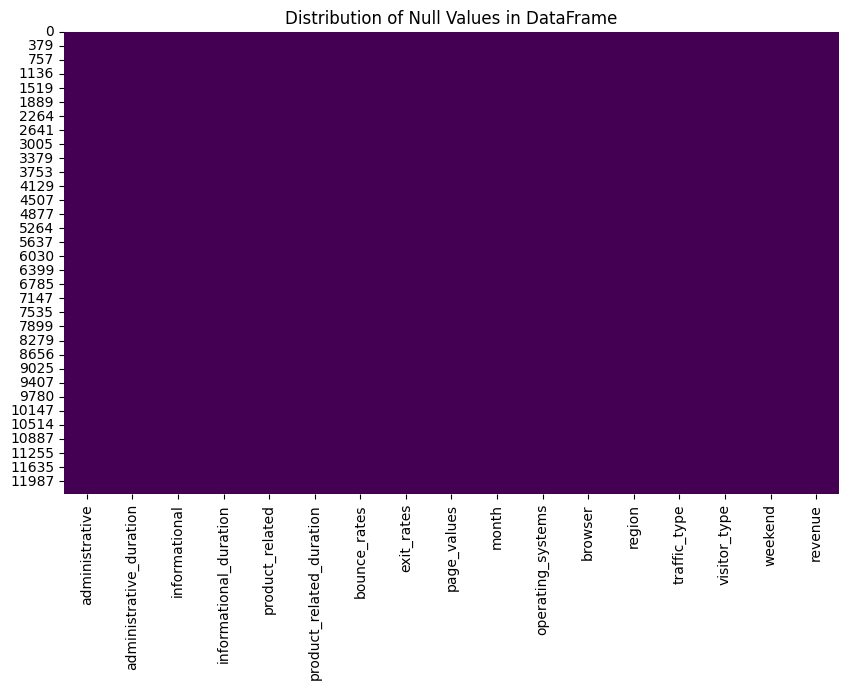

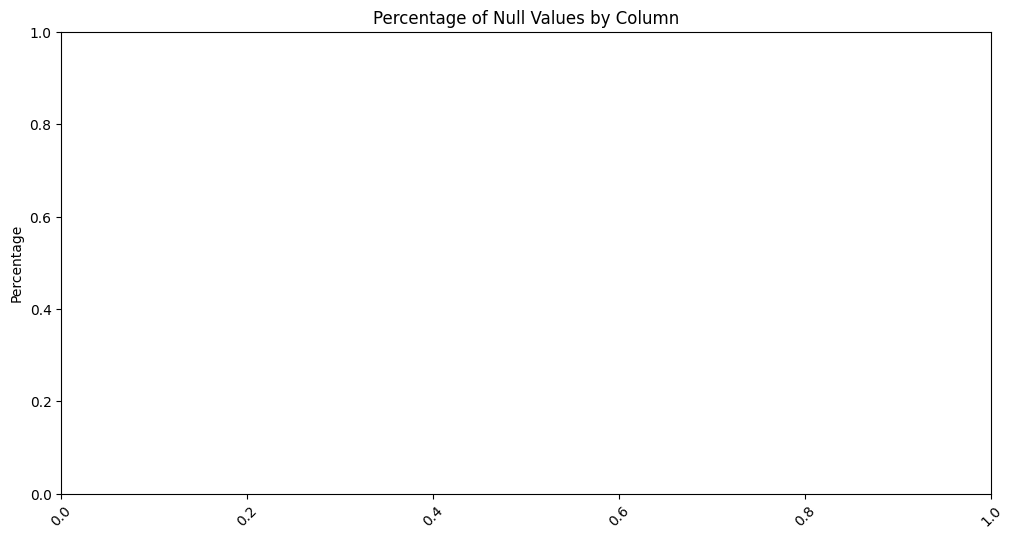

In [12]:

# Visualize the removal of NULL values
plotter.plot_null_distribution(df)
plotter.plot_null_percentage(df)


# Skewness

**Skewness** is a measure of the asymmetry of the probability distribution of a real-valued random variable about its mean. It quantifies how much a distribution deviates from a normal (Gaussian) distribution.

### Positive Skewness:

- When the skewness is greater than 0, the distribution is positively skewed.
- The right tail (higher values) is longer or fatter than the left.
- **Example**: Income distribution where a small number of people earn significantly higher than the average.

### Negative Skewness:

- When the skewness is less than 0, the distribution is negatively skewed.
- The left tail (lower values) is longer or fatter than the right.
- **Example**: Age at retirement where a small number of people retire much earlier than the average.

### Magnitude of Skewness:

- **Absolute skewness < |0.5|**: The data is fairly symmetrical.
- **Absolute skewness |0.5 - 1|**: Moderate skewness, often acceptable for many analyses.
- **Absolute skewness > |1|**: High skewness, likely requiring transformation or special handling.

### Calculation of Skewness

The skewness of a dataset is calculated using the formula:

\[ \text{Skewness} = \frac{n}{(n-1)(n-2)} \sum \left( \frac{x_i - \bar{x}}{s} \right)^3 \]

where:
- \( n \) is the number of data points.
- \( x_i \) is each individual data point.
- \( \bar{x} \) is the mean of the data.
- \( s \) is the standard deviation of the data.

### Reason to transform skewed data
It is important to check for skewdness because ...
Reasons to Transform Skewed Data
Transforming skewed data is a common preprocessing step in data analysis and can be motivated by a variety of factors:

***Machine Learning:***
Untransformed skewed data might lead to one end of the distribution being disproportionately represented in the analysis. Some algorithms (e.g., K-nearest neighbors, SVM, or linear regression-based models) can be highly sensitive to the scale and distribution of data. Transforming the data can help these algorithms perform better by ensuring a more uniform representation of the data.

***Normalisation:***
Many statistical techniques (like linear regression, ANOVA, t-tests, etc.) assume that the data follows a normal distribution. If the data is skewed, these techniques may give biased or inefficient results. Transforming the data can help to make it more normally distributed, thus satisfying the assumptions of these techniques.

***Reduction of the Impact of Outliers:***
Skewed data often has outliers that can disproportionately affect the results of an analysis. By transforming the data, the impact of these outliers can be reduced.

***Improving Interpretability:***
In some cases, transforming the data can make results more interpretable. For example, a log transformation can convert multiplicative relationships into additive ones and exponential relationships into linear ones.


### Threshold
We will set a threshold > |1|. Any value above 1 or under -1 we will transform it.



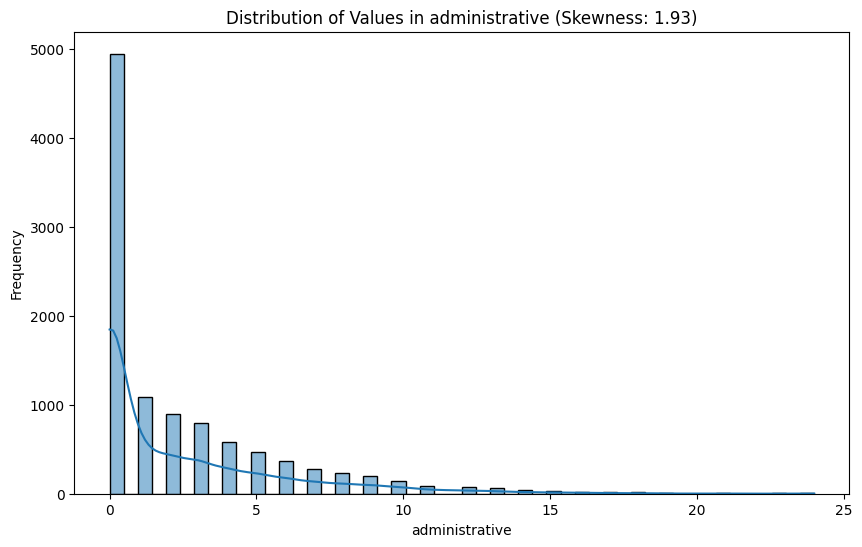

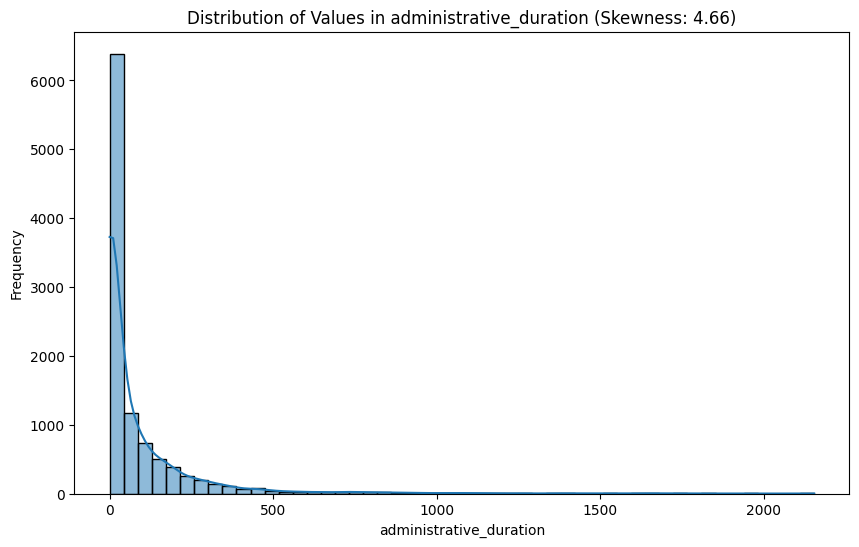

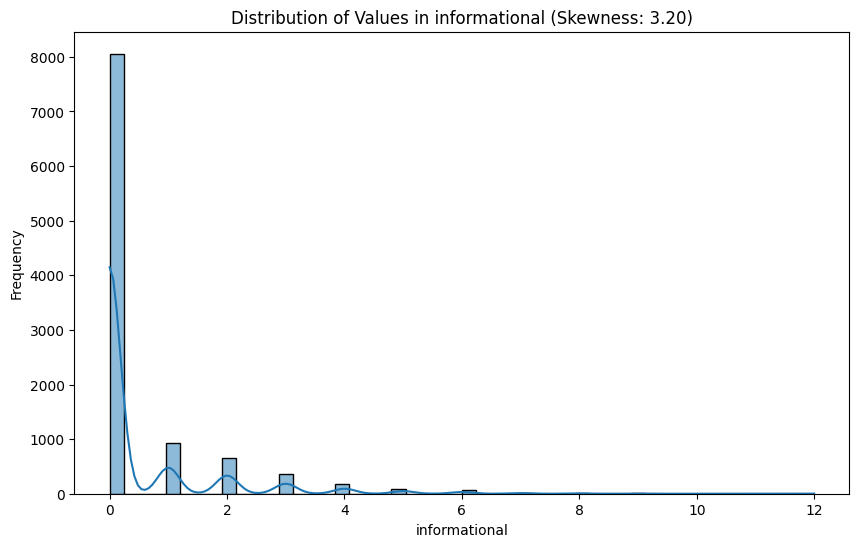

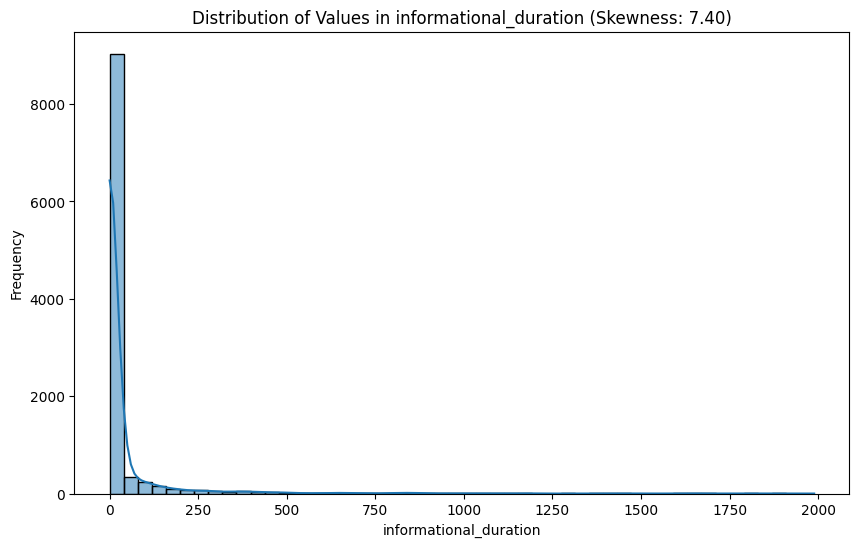

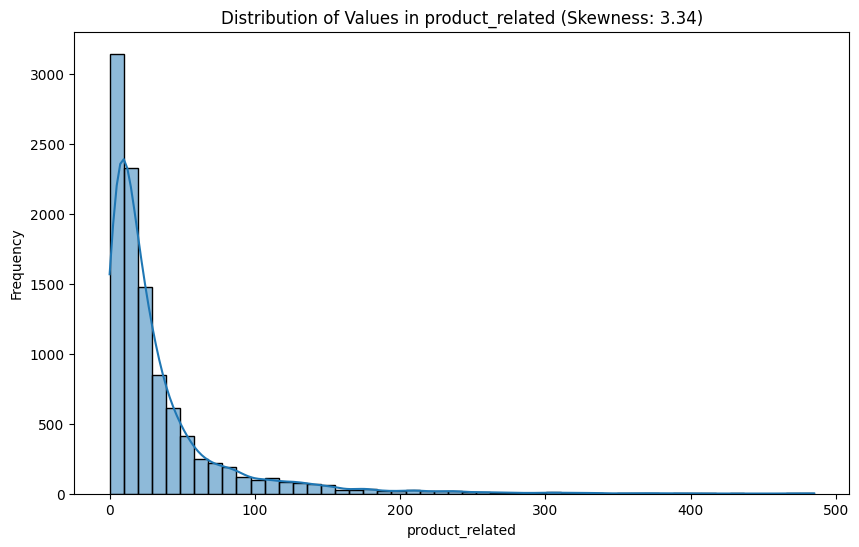

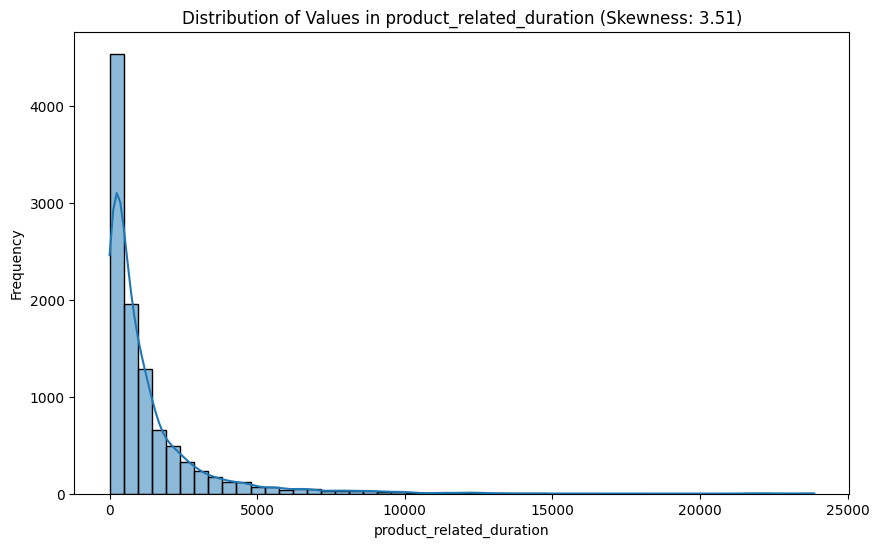

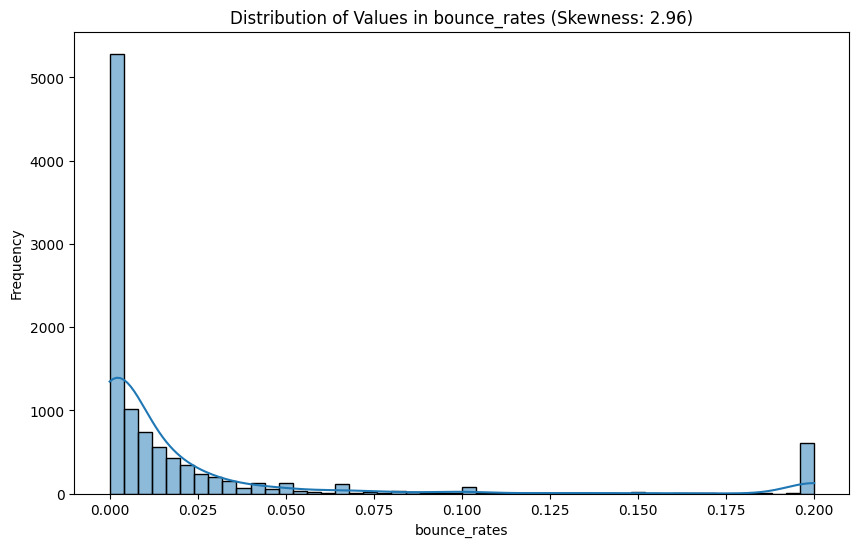

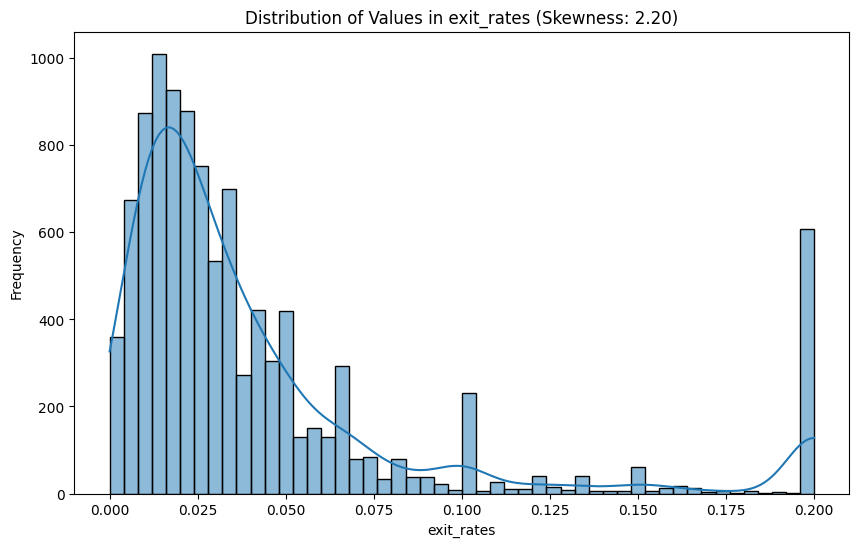

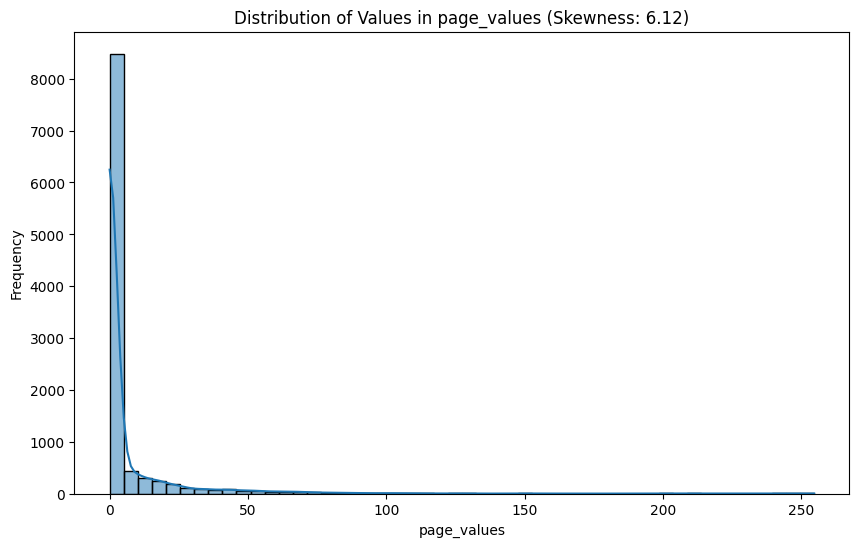

In [14]:
# Identifying the columns with the skewed data
# Identify skewed columns
selected_columns = df.select_dtypes(include=['float64', 'int64']).columns

plotter = Plotter()
plotter.plot_skewness(df, selected_columns)


## Analysis of the skewness of the Columns

After visualizing the skewness of each column, we have identified several columns that exhibit high skewness. These columns are:

- **Column 1**
- **Column 2**
- **Column 3**

### Transformations to Address Skewness

To address the skewness in these columns, we will apply a combination of log and Box-Cox transformation. These transformations help to make the data more normally distributed, which can improve the performance of machine learning models and the accuracy of statistical analyses.

#### Log Transformation
The log transformation is defined as:
```scsss
y = log(x)
```
#### Box-Cox Transformation
The Box-Cox transformation is defined as:

```scss
y = (x**λ - 1) / λ,  for λ ≠ 0
y = log(x), for λ = 0
```

These transformations will help stabilize variance, reduce the impact of outliers, and improve the interpretability of our data.


In [ ]:
To do:  
1. Talk about the skewness of the columns why they are all positively skewed. explain it with 
regatds to the nature of the dataset. for example the lowest is 0. or how the data is measured. See other aicores users github

2. Plot the categorical data distribution.

3. have the skewedness of all the columns, and the distribution of categorical data in a grid format to make it 
easier to read